In [1]:
import os
os.chdir('StableCascade')
import yaml
import torch
import zlib
import torch
import numpy as np
from tqdm import tqdm
from inference.utils import *
from core.utils import load_or_fail
from train import WurstCoreB
from scipy.stats import norm
from datasets import load_dataset

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
config_file_b = 'configs/inference/stage_b_3b.yaml'
with open(config_file_b, "r", encoding="utf-8") as file:
    config_file_b = yaml.safe_load(file)
    
core = WurstCoreB(config_dict=config_file_b, device=device, training=False)
extras = core.setup_extras_pre()
models = core.setup_models(extras)
models.generator.bfloat16();
extras.sampling_configs['cfg'] = 1.1
extras.sampling_configs['shift'] = 1
extras.sampling_configs['timesteps'] = 10
extras.sampling_configs['t_start'] = 1.0

['model_version', 'stage_a_checkpoint_path', 'effnet_checkpoint_path']
['transforms', 'clip_preprocess', 'gdf', 'sampling_configs', 'effnet_preprocess']


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

['tokenizer', 'text_model', 'generator', 'effnet', 'stage_a']


In [3]:
def decompress_b4(compressed_batch, original_shape=(16,16,16), c_clip=torch.zeros(4,1,1280).cuda(), u_clip=torch.zeros(4,1,1280).cuda()):
    with torch.no_grad(), torch.cuda.amp.autocast(dtype=torch.bfloat16):
        decompressed = [zlib.decompress(img) for img in compressed_batch]
        decompressed = [np.frombuffer(d, dtype=np.int8) for d in decompressed]
        decompressed = [d.reshape(original_shape) for d in decompressed]
        decompressed = [norm.ppf((d+0.5)/16) for d in decompressed]
        decompressed = [torch.tensor(d).cuda() for d in decompressed]
        decompressed = [d.unsqueeze(0) for d in decompressed]
        decompressed = torch.cat(decompressed)
        conditions = {
            'effnet': decompressed,
            'clip':   c_clip
        }
        unconditions = {
            'effnet': torch.zeros_like(decompressed),
            'clip':   u_clip
        }
        sampling_b = extras.gdf.sample(
            models.generator, conditions, (4, 4, 256, 256),
            unconditions, device=device, **extras.sampling_configs
        )
        print(decompressed.shape)
        for (sampled_b, _, _) in tqdm(sampling_b, total=extras.sampling_configs['timesteps']):
            sampled_b = sampled_b
        sampled = models.stage_a.decode(sampled_b).float()
        return sampled

torch.Size([4, 16, 16, 16])


100%|███████████████████████████████████████████████████████████████████████████████████| 10/10 [00:15<00:00,  1.51s/it]


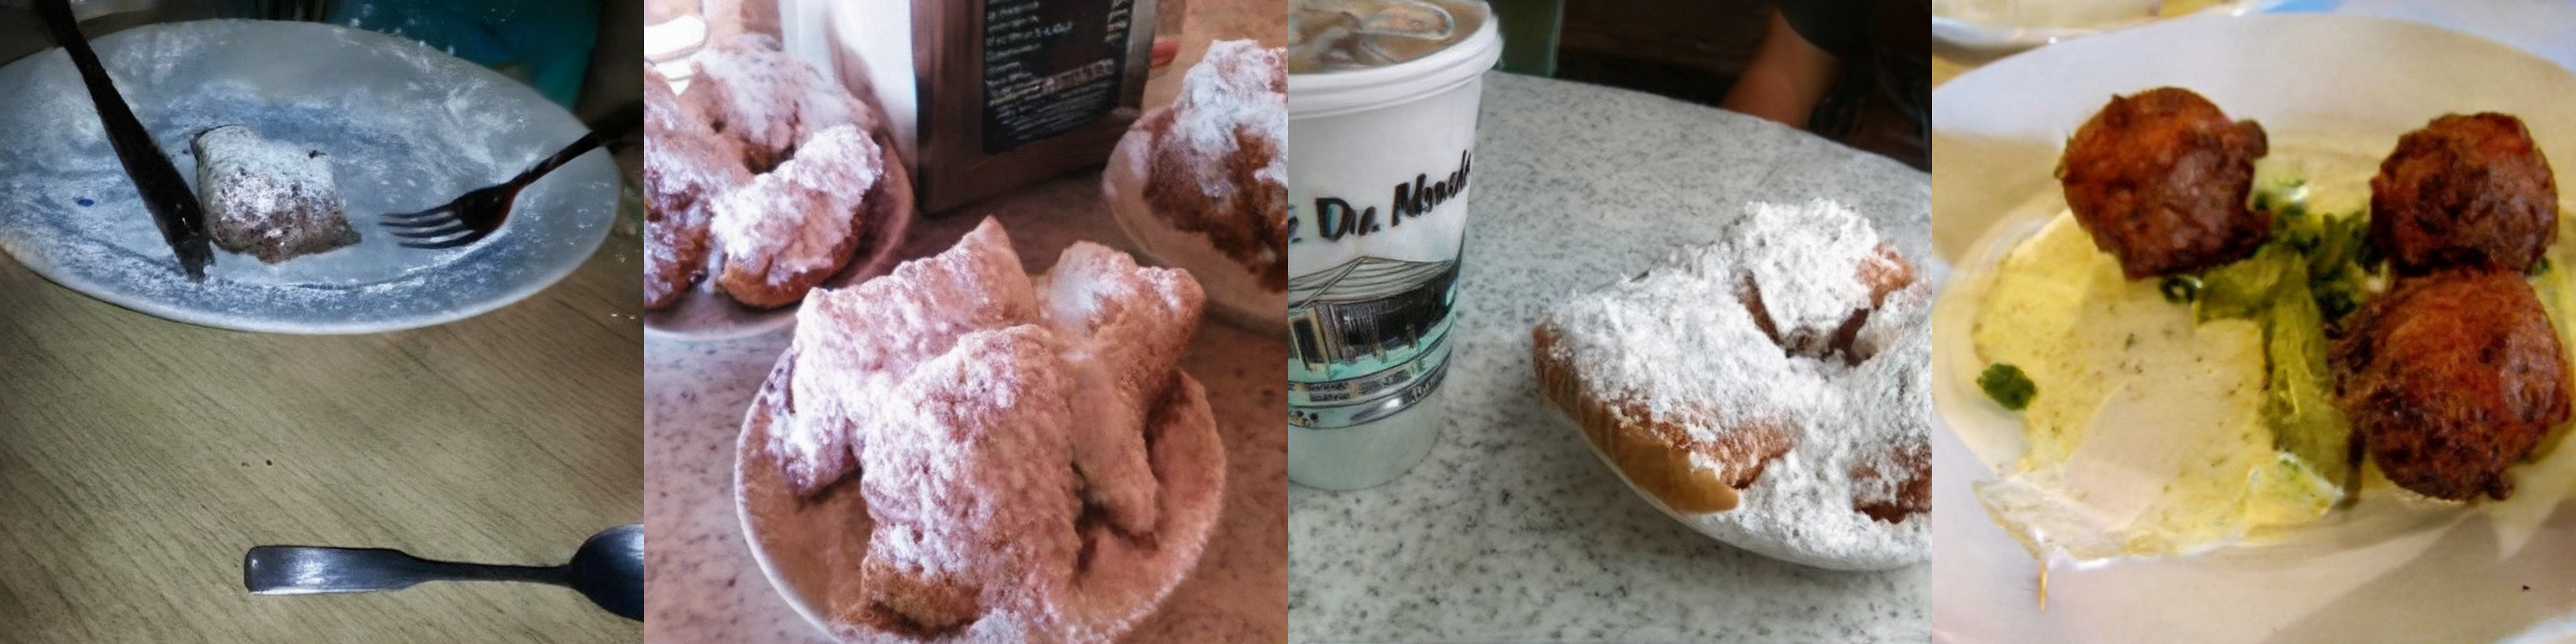

In [4]:
food101_train = load_dataset('danjacobellis/food101_cascade',split="train")
test_batch = food101_train[0:4]['compressed_image']
recovered_batch = decompress_b4(test_batch)
show_images(recovered_batch)